In [49]:
import pandas as pd
import numpy as np
import re

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

import matplotlib.pyplot as plt

import shap

import xgboost as xgb
from xgboost import XGBClassifier

from scipy.stats import randint

import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('wordnet')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer

[nltk_data] Downloading package stopwords to /Users/sven/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/sven/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /Users/sven/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /Users/sven/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /Users/sven/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
print(nltk.data.path)

['/Users/sven/nltk_data', '/opt/anaconda3/nltk_data', '/opt/anaconda3/share/nltk_data', '/opt/anaconda3/lib/nltk_data', '/usr/share/nltk_data', '/usr/local/share/nltk_data', '/usr/lib/nltk_data', '/usr/local/lib/nltk_data']


In [4]:
# Load the data
data_file = "training_data_lowercase.csv"
data = pd.read_csv(data_file, sep="\t", header=None)  # Load as tab-delimited file without headers

In [5]:
# Assign new column names
data.columns = ['label', 'text']

data.head(5)

,label,text
0,0,donald trump sends out embarrassing new year‚s...
1,0,drunk bragging trump staffer started russian c...
2,0,sheriff david clarke becomes an internet joke ...
3,0,trump is so obsessed he even has obama‚s name ...
4,0,pope francis just called out donald trump duri...


In [6]:
# Remove special characters
data['text'] = data['text'].str.replace(r'[^a-z0-9\s]', '', regex=True)

In [7]:
stop_words = set(stopwords.words('english'))

In [8]:
# Tokenize and remove stopwords for each text entry in the dataframe
data['filtered_text'] = data['text'].apply(lambda x: [word for word in word_tokenize(x) if word.lower() not in stop_words])

In [9]:
# Lemmatization of text to leverage the context as well

# from nltk.stem import WordNetLemmatizer
# from nltk.corpus import wordnet

# Initialize the lemmatizer
lemmatizer = WordNetLemmatizer()

# Function to get part-of-speech (POS) tagging for more accurate lemmatization
def get_wordnet_pos(word):
    from nltk.corpus import wordnet
    from nltk import pos_tag
    tag = pos_tag([word])[0][1][0].upper()
    tag_dict = {
        'J': wordnet.ADJ,  # Adjective
        'N': wordnet.NOUN,  # Noun
        'V': wordnet.VERB,  # Verb
        'R': wordnet.ADV   # Adverb
    }
    return tag_dict.get(tag, wordnet.NOUN)  # Default to noun

# Apply lemmatization to the filtered_text column
data['lemmatized_text'] = data['filtered_text'].apply(
    lambda tokens: [lemmatizer.lemmatize(word, get_wordnet_pos(word)) for word in tokens]
)

# Display the first few rows to verify the result
print(data.head())

   label                                               text  \
0      0  donald trump sends out embarrassing new years ...   
1      0  drunk bragging trump staffer started russian c...   
2      0  sheriff david clarke becomes an internet joke ...   
3      0  trump is so obsessed he even has obamas name c...   
4      0  pope francis just called out donald trump duri...   

                                       filtered_text  \
0  [donald, trump, sends, embarrassing, new, year...   
1  [drunk, bragging, trump, staffer, started, rus...   
2  [sheriff, david, clarke, becomes, internet, jo...   
3  [trump, obsessed, even, obamas, name, coded, w...   
4  [pope, francis, called, donald, trump, christm...   

                                     lemmatized_text  
0  [donald, trump, sends, embarrass, new, year, e...  
1  [drunk, bragging, trump, staffer, start, russi...  
2  [sheriff, david, clarke, becomes, internet, jo...  
3  [trump, obsess, even, obamas, name, cod, websi...  
4  [pope,

In [10]:
print(data['lemmatized_text'])

0        [donald, trump, sends, embarrass, new, year, e...
1        [drunk, bragging, trump, staffer, start, russi...
2        [sheriff, david, clarke, becomes, internet, jo...
3        [trump, obsess, even, obamas, name, cod, websi...
4        [pope, francis, call, donald, trump, christmas...
                               ...                        
34147      [tear, rain, thai, gather, late, king, funeral]
34148    [pyongyang, university, need, nonus, teacher, ...
34149    [philippine, president, duterte, visit, japan,...
34150    [japan, abe, may, election, many, dont, want, pm]
34151    [demoralize, divide, inside, catalonia, police...
Name: lemmatized_text, Length: 34152, dtype: object


In [11]:
# Combine tokens into single text strings for each row in 'lemmatized_text'
data['lemmatized_text'] = data['lemmatized_text'].apply(lambda tokens: ' '.join(tokens))



In [12]:
# Initialize TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(
    max_features=100,  # Limit to top 5000 words 
    stop_words='english',  # Exclude common stopwords 
    ngram_range=(1, 2)  # Consider unigrams and bigrams 
)

In [13]:
print(data['lemmatized_text'])

0        donald trump sends embarrass new year eve mess...
1        drunk bragging trump staffer start russian col...
2        sheriff david clarke becomes internet joke thr...
3          trump obsess even obamas name cod website image
4          pope francis call donald trump christmas speech
                               ...                        
34147              tear rain thai gather late king funeral
34148    pyongyang university need nonus teacher travel...
34149    philippine president duterte visit japan ahead...
34150             japan abe may election many dont want pm
34151      demoralize divide inside catalonia police force
Name: lemmatized_text, Length: 34152, dtype: object


In [14]:
# Fit and transform the lemmatized text column
tfidf_matrix = tfidf_vectorizer.fit_transform(data['lemmatized_text'])

In [15]:
print(data['lemmatized_text'])

0        donald trump sends embarrass new year eve mess...
1        drunk bragging trump staffer start russian col...
2        sheriff david clarke becomes internet joke thr...
3          trump obsess even obamas name cod website image
4          pope francis call donald trump christmas speech
                               ...                        
34147              tear rain thai gather late king funeral
34148    pyongyang university need nonus teacher travel...
34149    philippine president duterte visit japan ahead...
34150             japan abe may election many dont want pm
34151      demoralize divide inside catalonia police force
Name: lemmatized_text, Length: 34152, dtype: object


In [16]:
# Convert the resulting sparse matrix to a DataFrame for analysis
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names_out())


In [17]:
print(data['lemmatized_text'])

0        donald trump sends embarrass new year eve mess...
1        drunk bragging trump staffer start russian col...
2        sheriff david clarke becomes internet joke thr...
3          trump obsess even obamas name cod website image
4          pope francis call donald trump christmas speech
                               ...                        
34147              tear rain thai gather late king funeral
34148    pyongyang university need nonus teacher travel...
34149    philippine president duterte visit japan ahead...
34150             japan abe may election many dont want pm
34151      demoralize divide inside catalonia police force
Name: lemmatized_text, Length: 34152, dtype: object


In [18]:
# Display the first few rows of the TF-IDF DataFrame
print(tfidf_df.head(50))

    america  american    attack  ban     black    break  campaign  chief  \
0       0.0       0.0  0.000000  0.0  0.000000  0.00000  0.000000    0.0   
1       0.0       0.0  0.000000  0.0  0.000000  0.00000  0.000000    0.0   
2       0.0       0.0  0.000000  0.0  0.000000  0.00000  0.000000    0.0   
3       0.0       0.0  0.000000  0.0  0.000000  0.00000  0.000000    0.0   
4       0.0       0.0  0.000000  0.0  0.000000  0.00000  0.000000    0.0   
5       0.0       0.0  0.000000  0.0  0.677261  0.00000  0.000000    0.0   
6       0.0       0.0  0.000000  0.0  0.000000  0.00000  0.000000    0.0   
7       0.0       0.0  0.000000  0.0  0.000000  0.00000  0.000000    0.0   
8       0.0       0.0  0.000000  0.0  0.000000  0.00000  0.000000    0.0   
9       0.0       0.0  0.000000  0.0  0.000000  0.00000  0.000000    0.0   
10      0.0       0.0  0.000000  0.0  0.000000  0.00000  0.000000    0.0   
11      0.0       0.0  0.000000  0.0  0.000000  0.00000  0.000000    0.0   
12      0.0 

In [19]:
print(data['lemmatized_text'].head(10))
print(data['lemmatized_text'].isna().sum())  # Check for NaN values
print(data['lemmatized_text'].apply(len).describe())  # Analyze lengths of text

0    donald trump sends embarrass new year eve mess...
1    drunk bragging trump staffer start russian col...
2    sheriff david clarke becomes internet joke thr...
3      trump obsess even obamas name cod website image
4      pope francis call donald trump christmas speech
5    racist alabama cop brutalize black boy handcuf...
6                                    fresh golf course
7    trump say insanely racist stuff inside oval of...
8           former cia director slam trump un bullying
9     brandnew protrump ad feature much kiss make sick
Name: lemmatized_text, dtype: object
0
count    34152.000000
mean        59.058562
std         17.687234
min          0.000000
25%         49.000000
50%         57.000000
75%         67.000000
max        229.000000
Name: lemmatized_text, dtype: float64


In [ ]:
# Define feature set and split into training and test

X = tfidf_df
y = data['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [24]:
# Initialize Random Forest Model

rf_classifier = RandomForestClassifier(random_state=42)

# Train Random Forest Model

rf_classifier.fit(X_train, y_train)

# Make predictions on the test data

y_pred_rf = rf_classifier.predict(X_test)

In [25]:
# Accuracy
accuracy = accuracy_score(y_test, y_pred_rf)
print(f"Accuracy: {accuracy:.2f}")

# Confusion Matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf))

# Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred_rf))

Accuracy: 0.81
Confusion Matrix:
[[2625  904]
 [ 381 2921]]
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.74      0.80      3529
           1       0.76      0.88      0.82      3302

    accuracy                           0.81      6831
   macro avg       0.82      0.81      0.81      6831
weighted avg       0.82      0.81      0.81      6831



In [27]:
# Define a grid of hyperparameters
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize GridSearchCV
grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=param_grid,
    cv=3,  # 3-fold cross-validation
    n_jobs=-1,  # Use all available processors
    verbose=2
)

# Fit to the training data
grid_search.fit(X_train, y_train)

# Print best parameters and score
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

# Train a model with the best parameters
optimized_rf = grid_search.best_estimator_

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   2.1s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   2.1s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   2.2s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   2.2s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   2.2s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   2.2s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   4.3s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   2.1s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   4.4s
[CV] END 

In [28]:
optimized_rf = grid_search.best_estimator_

In [29]:
# Make predictions on the test data
y_pred = optimized_rf.predict(X_test)

# Calculate accuracy score
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy on Test Data:", accuracy)

Accuracy on Test Data: 0.81174059434929


In [31]:
# Define a parameter distribution
param_dist = {
    'n_estimators': randint(100, 500),  # Random values between 100 and 500
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 5)
}

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_distributions=param_dist,
    n_iter=50,  # Number of random combinations to try
    cv=3,  # 3-fold cross-validation
    n_jobs=-1,  # Use all available processors
    verbose=2,
    random_state=42
)

# Fit to the training data
random_search.fit(X_train, y_train)

# Print best parameters and score
print("Best Parameters:", random_search.best_params_)
print("Best Score:", random_search.best_score_)

# Train a model with the best parameters
optimized_rf = random_search.best_estimator_

Fitting 3 folds for each of 50 candidates, totalling 150 fits
[CV] END max_depth=20, min_samples_leaf=4, min_samples_split=6, n_estimators=120; total time=   1.2s
[CV] END max_depth=20, min_samples_leaf=4, min_samples_split=6, n_estimators=120; total time=   1.3s
[CV] END max_depth=20, min_samples_leaf=4, min_samples_split=6, n_estimators=120; total time=   1.3s
[CV] END max_depth=30, min_samples_leaf=4, min_samples_split=9, n_estimators=230; total time=   2.9s
[CV] END max_depth=30, min_samples_leaf=4, min_samples_split=9, n_estimators=230; total time=   3.0s
[CV] END max_depth=20, min_samples_leaf=2, min_samples_split=4, n_estimators=314; total time=   3.4s
[CV] END max_depth=20, min_samples_leaf=2, min_samples_split=4, n_estimators=314; total time=   3.4s
[CV] END max_depth=20, min_samples_leaf=2, min_samples_split=4, n_estimators=314; total time=   3.4s
[CV] END max_depth=20, min_samples_leaf=4, min_samples_split=6, n_estimators=370; total time=   3.9s
[CV] END max_depth=20, min_sa

In [32]:
# Make predictions on the test data
y_pred = optimized_rf.predict(X_test)

# Calculate accuracy score
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy on Test Data:", accuracy)

Accuracy on Test Data: 0.8123261601522471


In [33]:
!pip install xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 18.2 MB/s eta 0:00:00


In [35]:
# Initialize the XGBoost Classifier
xgb_model = XGBClassifier(
    n_estimators=100,   # Number of trees
    learning_rate=0.1,  # Step size shrinkage
    max_depth=6,        # Maximum depth of a tree
    use_label_encoder=False,  # Avoid unnecessary label encoding warnings
    eval_metric='logloss'  # Evaluation metric for classification
)

# Train the model
xgb_model.fit(X_train, y_train)

/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:27:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [36]:
# Predict on the test set
y_pred = xgb_model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Print a classification report
print(classification_report(y_test, y_pred))

Accuracy: 0.80
              precision    recall  f1-score   support

           0       0.91      0.68      0.78      3529
           1       0.73      0.93      0.82      3302

    accuracy                           0.80      6831
   macro avg       0.82      0.81      0.80      6831
weighted avg       0.82      0.80      0.80      6831



In [37]:
# Define a parameter grid
param_grid = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [4, 6, 8],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Initialize GridSearchCV
grid_search = GridSearchCV(
    estimator=XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    param_grid=param_grid,
    cv=3,  # 3-fold cross-validation
    scoring='accuracy',
    verbose=2,
    n_jobs=-1
)

# Fit to training data
grid_search.fit(X_train, y_train)

# Best parameters
print("Best Parameters:", grid_search.best_params_)

# Train the final model with best parameters
best_xgb_model = grid_search.best_estimator_

Fitting 3 folds for each of 108 candidates, totalling 324 fits


/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:30:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:30:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:30:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:30:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packa

[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, n_estimators=50, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, n_estimators=50, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, n_estimators=50, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, n_estimators=50, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, n_estimators=50, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, n_estimators=50, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, n_estimators=100, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, n_estimators=100, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, n_estimators=1

/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:30:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:30:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:30:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:30:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packa

[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, n_estimators=150, subsample=0.8; total time=   0.5s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, n_estimators=150, subsample=0.8; total time=   0.5s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, n_estimators=50, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, n_estimators=50, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, n_estimators=50, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, n_estimators=50, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, n_estimators=50, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, n_estimators=50, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, n_estimators=1

/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:30:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:30:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:30:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:30:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packa

[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, n_estimators=150, subsample=1.0; total time=   0.5s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, n_estimators=150, subsample=1.0; total time=   0.5s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, n_estimators=100, subsample=0.8; total time=   0.4s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, n_estimators=100, subsample=0.8; total time=   0.4s


/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:30:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:30:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:30:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, n_estimators=100, subsample=1.0; total time=   0.4s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, n_estimators=100, subsample=0.8; total time=   0.4s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, n_estimators=100, subsample=1.0; total time=   0.5s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=8, n_estimators=50, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=8, n_estimators=50, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, n_estimators=100, subsample=1.0; total time=   0.5s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=8, n_estimators=50, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=8, n_estimators=50, subsample=1.0; total time=   0.3s


/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:30:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:30:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:30:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:30:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packa

[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, n_estimators=150, subsample=0.8; total time=   0.6s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, n_estimators=150, subsample=0.8; total time=   0.6s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, n_estimators=150, subsample=1.0; total time=   0.6s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, n_estimators=150, subsample=0.8; total time=   0.6s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, n_estimators=150, subsample=1.0; total time=   0.6s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, n_estimators=150, subsample=1.0; total time=   0.6s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=8, n_estimators=50, subsample=1.0; total time=   0.4s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=8, n_estimators=50, subsample=1.0; total time=   0.4s


/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:30:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:30:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:30:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:30:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packa

[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, n_estimators=50, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, n_estimators=50, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=8, n_estimators=100, subsample=0.8; total time=   0.5s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=8, n_estimators=100, subsample=0.8; total time=   0.6s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=8, n_estimators=100, subsample=0.8; total time=   0.6s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=8, n_estimators=100, subsample=1.0; total time=   0.6s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=8, n_estimators=100, subsample=1.0; total time=   0.5s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, n_estimators=50, subsample=0.8; total time=   0.2s


/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:30:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:30:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:30:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:30:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packa

[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=8, n_estimators=100, subsample=1.0; total time=   0.6s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, n_estimators=50, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, n_estimators=50, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, n_estimators=50, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, n_estimators=100, subsample=0.8; total time=   0.3s


/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:30:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:30:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:30:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:30:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packa

[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, n_estimators=100, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, n_estimators=100, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=8, n_estimators=150, subsample=0.8; total time=   0.7s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=8, n_estimators=150, subsample=0.8; total time=   0.8s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=8, n_estimators=150, subsample=0.8; total time=   0.8s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, n_estimators=100, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, n_estimators=100, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, n_estimators=100, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=8, n_estimators=

/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:30:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:30:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:30:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:30:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packa

[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, n_estimators=150, subsample=0.8; total time=   0.4s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, n_estimators=150, subsample=0.8; total time=   0.4s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, n_estimators=50, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, n_estimators=50, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, n_estimators=50, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, n_estimators=50, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, n_estimators=50, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, n_estimators=50, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, n_estimators=150, subsa

/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:30:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:30:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:30:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:30:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packa

[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, n_estimators=150, subsample=1.0; total time=   0.4s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, n_estimators=150, subsample=1.0; total time=   0.5s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, n_estimators=100, subsample=0.8; total time=   0.4s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, n_estimators=100, subsample=0.8; total time=   0.4s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, n_estimators=100, subsample=1.0; total time=   0.4s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, n_estimators=100, subsample=0.8; total time=   0.4s


/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:30:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:30:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:30:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:30:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packa

[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, n_estimators=100, subsample=1.0; total time=   0.4s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, n_estimators=100, subsample=1.0; total time=   0.5s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=8, n_estimators=50, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=8, n_estimators=50, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, n_estimators=150, subsample=1.0; total time=   0.5s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=8, n_estimators=50, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=8, n_estimators=50, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, n_estimators=150, subsample=0.8; total time=   0.6s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, n_estimators=150, sub

/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:30:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:30:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:30:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:30:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packa

[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, n_estimators=150, subsample=1.0; total time=   0.6s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, n_estimators=150, subsample=1.0; total time=   0.5s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=8, n_estimators=50, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=8, n_estimators=50, subsample=1.0; total time=   0.4s


/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:30:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:30:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:30:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=4, n_estimators=50, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=4, n_estimators=50, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=8, n_estimators=100, subsample=0.8; total time=   0.5s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=8, n_estimators=100, subsample=0.8; total time=   0.5s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=8, n_estimators=100, subsample=0.8; total time=   0.6s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=8, n_estimators=100, subsample=1.0; total time=   0.5s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=8, n_estimators=100, subsample=1.0; total time=   0.5s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=8, n_estimators=100, subsample=1.0; total time=   0.6s


/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:30:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:30:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:30:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:30:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packa

[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=4, n_estimators=50, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=4, n_estimators=50, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=4, n_estimators=50, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=4, n_estimators=50, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=8, n_estimators=150, subsample=0.8; total time=   0.7s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=8, n_estimators=150, subsample=0.8; total time=   0.7s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=8, n_estimators=150, subsample=0.8; total time=   0.7s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=4, n_estimators=100, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=8, n_estimators=150, sub

/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:30:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:30:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:30:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:30:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packa

[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=4, n_estimators=100, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=8, n_estimators=150, subsample=1.0; total time=   0.7s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=4, n_estimators=100, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=8, n_estimators=150, subsample=1.0; total time=   0.7s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=4, n_estimators=100, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=4, n_estimators=100, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=4, n_estimators=100, subsample=1.0; total time=   0.3s


/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:30:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:30:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:30:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:30:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packa

[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=6, n_estimators=50, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=4, n_estimators=150, subsample=0.8; total time=   0.4s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=6, n_estimators=50, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=4, n_estimators=150, subsample=0.8; total time=   0.4s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=6, n_estimators=50, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=6, n_estimators=50, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=6, n_estimators=50, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=4, n_estimators=150, subsample=1.0; total time=   0.4s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=4, n_estimators=150, subs

/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:30:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:30:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:30:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:30:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packa

[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=6, n_estimators=100, subsample=0.8; total time=   0.4s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=6, n_estimators=100, subsample=0.8; total time=   0.4s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=6, n_estimators=100, subsample=1.0; total time=   0.4s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=6, n_estimators=100, subsample=0.8; total time=   0.4s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=6, n_estimators=100, subsample=1.0; total time=   0.4s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=8, n_estimators=50, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=6, n_estimators=100, subsample=1.0; total time=   0.4s


/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:30:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:30:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:30:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:30:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packa

[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=8, n_estimators=50, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=8, n_estimators=50, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=6, n_estimators=150, subsample=0.8; total time=   0.6s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=8, n_estimators=50, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=6, n_estimators=150, subsample=0.8; total time=   0.5s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=6, n_estimators=150, subsample=0.8; total time=   0.5s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=6, n_estimators=150, subsample=1.0; total time=   0.5s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=6, n_estimators=150, subsample=1.0; total time=   0.5s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=6, n_estimators=150, su

/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:30:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:30:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:30:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:30:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packa

[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=8, n_estimators=50, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=8, n_estimators=100, subsample=0.8; total time=   0.5s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=4, n_estimators=50, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=4, n_estimators=50, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=8, n_estimators=100, subsample=0.8; total time=   0.5s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=8, n_estimators=100, subsample=0.8; total time=   0.5s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=8, n_estimators=100, subsample=1.0; total time=   0.5s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=8, n_estimators=100, subsample=1.0; total time=   0.5s


/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:30:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:30:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:30:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:30:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packa

[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=4, n_estimators=50, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=4, n_estimators=50, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=8, n_estimators=100, subsample=1.0; total time=   0.6s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=4, n_estimators=50, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=4, n_estimators=50, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=8, n_estimators=150, subsample=0.8; total time=   0.6s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=8, n_estimators=150, subsample=0.8; total time=   0.7s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=8, n_estimators=150, subsample=1.0; total time=   0.7s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=8, n_estimators=150,

/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:30:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:30:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:30:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:30:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packa

[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=8, n_estimators=150, subsample=1.0; total time=   0.7s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=4, n_estimators=100, subsample=0.8; total time=   0.4s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=4, n_estimators=100, subsample=0.8; total time=   0.4s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=4, n_estimators=100, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=4, n_estimators=100, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=4, n_estimators=100, subsample=1.0; total time=   0.4s


/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:30:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:30:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:30:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:30:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packa

[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=6, n_estimators=50, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=6, n_estimators=50, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=6, n_estimators=50, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=6, n_estimators=50, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=4, n_estimators=150, subsample=0.8; total time=   0.5s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=4, n_estimators=150, subsample=0.8; total time=   0.5s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=6, n_estimators=50, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=4, n_estimators=150, subsample=1.0; total time=   0.5s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=4, n_estimators=

/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:30:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:30:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:30:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:30:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packa

[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=6, n_estimators=100, subsample=0.8; total time=   0.5s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=6, n_estimators=100, subsample=0.8; total time=   0.5s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=6, n_estimators=100, subsample=0.8; total time=   0.5s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=6, n_estimators=100, subsample=1.0; total time=   0.5s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=8, n_estimators=50, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=8, n_estimators=50, subsample=0.8; total time=   0.3s


/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:30:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:30:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:30:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:30:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packa

[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=6, n_estimators=100, subsample=1.0; total time=   0.5s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=6, n_estimators=100, subsample=1.0; total time=   0.5s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=8, n_estimators=50, subsample=0.8; total time=   0.4s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=6, n_estimators=150, subsample=0.8; total time=   0.7s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=6, n_estimators=150, subsample=0.8; total time=   0.7s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=6, n_estimators=150, subsample=0.8; total time=   0.7s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=6, n_estimators=150, subsample=1.0; total time=   0.7s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=8, n_estimators=50, subsample=1.0; total time=   0.4s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=8, n_estimato

/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:30:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:30:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:30:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:30:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packa

[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=4, n_estimators=50, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=8, n_estimators=100, subsample=0.8; total time=   0.6s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=4, n_estimators=50, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=8, n_estimators=100, subsample=0.8; total time=   0.6s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=8, n_estimators=100, subsample=0.8; total time=   0.7s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=8, n_estimators=100, subsample=1.0; total time=   0.7s


/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:30:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:30:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:30:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:30:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packa

[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=4, n_estimators=50, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=8, n_estimators=100, subsample=1.0; total time=   0.6s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=4, n_estimators=50, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=4, n_estimators=50, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=4, n_estimators=50, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=8, n_estimators=100, subsample=1.0; total time=   0.7s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=4, n_estimators=100, subsample=0.8; total time=   0.3s


/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:30:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:30:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:30:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:30:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packa

[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=4, n_estimators=100, subsample=0.8; total time=   0.4s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=4, n_estimators=100, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=8, n_estimators=150, subsample=0.8; total time=   0.9s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=8, n_estimators=150, subsample=0.8; total time=   0.9s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=8, n_estimators=150, subsample=0.8; total time=   0.9s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=8, n_estimators=150, subsample=1.0; total time=   0.8s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=4, n_estimators=100, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=4, n_estimators=100, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=4, n_estimators=

/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:30:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:30:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:30:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:30:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packa

[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=4, n_estimators=150, subsample=0.8; total time=   0.5s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=6, n_estimators=50, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=6, n_estimators=50, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=6, n_estimators=50, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=6, n_estimators=50, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=6, n_estimators=50, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=6, n_estimators=50, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=4, n_estimators=150, subsample=0.8; total time=   0.5s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=4, n_estimators=150, subsa

/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:30:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:30:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:30:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:30:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packa

[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=4, n_estimators=150, subsample=1.0; total time=   0.4s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=4, n_estimators=150, subsample=1.0; total time=   0.4s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=6, n_estimators=100, subsample=0.8; total time=   0.4s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=6, n_estimators=100, subsample=0.8; total time=   0.5s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=6, n_estimators=100, subsample=0.8; total time=   0.4s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=6, n_estimators=100, subsample=1.0; total time=   0.4s


/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:30:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:30:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:30:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:30:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packa

[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=6, n_estimators=100, subsample=1.0; total time=   0.4s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=8, n_estimators=50, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=8, n_estimators=50, subsample=0.8; total time=   0.4s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=6, n_estimators=100, subsample=1.0; total time=   0.5s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=8, n_estimators=50, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=6, n_estimators=150, subsample=0.8; total time=   0.6s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=6, n_estimators=150, subsample=0.8; total time=   0.6s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=6, n_estimators=150, subsample=1.0; total time=   0.6s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=6, n_estimators=150, su

/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:30:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:30:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:30:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:30:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packa

[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=8, n_estimators=50, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=6, n_estimators=150, subsample=0.8; total time=   0.6s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=8, n_estimators=50, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=6, n_estimators=150, subsample=1.0; total time=   0.6s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=8, n_estimators=50, subsample=1.0; total time=   0.4s


/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:30:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:30:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:30:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:30:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packa

[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=4, n_estimators=50, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=4, n_estimators=50, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=8, n_estimators=100, subsample=0.8; total time=   0.6s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=8, n_estimators=100, subsample=1.0; total time=   0.6s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=8, n_estimators=100, subsample=0.8; total time=   0.6s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=8, n_estimators=100, subsample=0.8; total time=   0.6s


/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:30:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:30:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:30:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:30:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packa

[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=4, n_estimators=50, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=8, n_estimators=100, subsample=1.0; total time=   0.6s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=4, n_estimators=50, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=4, n_estimators=50, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=8, n_estimators=100, subsample=1.0; total time=   0.7s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=4, n_estimators=50, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=8, n_estimators=150, subsample=0.8; total time=   0.8s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=8, n_estimators=150, subsample=0.8; total time=   0.7s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=8, n_estimators=150, sub

/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:30:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:30:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:30:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:30:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packa

[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=8, n_estimators=150, subsample=1.0; total time=   0.8s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=8, n_estimators=150, subsample=1.0; total time=   0.8s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=4, n_estimators=100, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=8, n_estimators=150, subsample=1.0; total time=   0.8s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=4, n_estimators=100, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=4, n_estimators=100, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=4, n_estimators=100, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=4, n_estimators=100, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=4, n_estimators=100,

/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:30:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:30:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:30:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:30:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packa

[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=4, n_estimators=150, subsample=0.8; total time=   0.4s


/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:30:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:30:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:30:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:30:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packa

[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=6, n_estimators=50, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=6, n_estimators=50, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=6, n_estimators=50, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=6, n_estimators=50, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=4, n_estimators=150, subsample=1.0; total time=   0.4s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=4, n_estimators=150, subsample=0.8; total time=   0.4s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=6, n_estimators=50, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=4, n_estimators=150, subsample=1.0; total time=   0.4s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=6, n_estimators=50, subsa

/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:30:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:30:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:30:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:30:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packa

[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=4, n_estimators=150, subsample=0.8; total time=   0.5s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=4, n_estimators=150, subsample=1.0; total time=   0.5s


/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:30:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:30:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=6, n_estimators=100, subsample=0.8; total time=   0.4s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=6, n_estimators=100, subsample=0.8; total time=   0.5s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=6, n_estimators=100, subsample=1.0; total time=   0.4s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=6, n_estimators=100, subsample=1.0; total time=   0.4s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=6, n_estimators=100, subsample=0.8; total time=   0.4s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=6, n_estimators=100, subsample=1.0; total time=   0.4s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=8, n_estimators=50, subsample=0.8; total time=   0.3s


/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:30:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:30:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:30:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:30:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packa

[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=6, n_estimators=150, subsample=0.8; total time=   0.6s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=6, n_estimators=150, subsample=0.8; total time=   0.6s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=6, n_estimators=150, subsample=1.0; total time=   0.6s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=6, n_estimators=150, subsample=1.0; total time=   0.6s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=8, n_estimators=50, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=8, n_estimators=50, subsample=0.8; total time=   0.4s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=6, n_estimators=150, subsample=0.8; total time=   0.6s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=6, n_estimators=150, subsample=1.0; total time=   0.6s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=8, n_estimators=50, su

/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:30:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:30:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:30:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:30:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packa

[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=8, n_estimators=100, subsample=0.8; total time=   0.5s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=8, n_estimators=100, subsample=0.8; total time=   0.5s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=8, n_estimators=100, subsample=1.0; total time=   0.5s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=8, n_estimators=100, subsample=1.0; total time=   0.5s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=8, n_estimators=100, subsample=1.0; total time=   0.5s


/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:30:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=8, n_estimators=150, subsample=0.8; total time=   0.6s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=8, n_estimators=150, subsample=0.8; total time=   0.6s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=8, n_estimators=150, subsample=0.8; total time=   0.6s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=8, n_estimators=150, subsample=1.0; total time=   0.6s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=8, n_estimators=150, subsample=1.0; total time=   0.6s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=8, n_estimators=150, subsample=1.0; total time=   0.6s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=8, n_estimators=100, subsample=0.8; total time=   0.4s


/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:30:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.2, 'max_depth': 6, 'n_estimators': 150, 'subsample': 1.0}


In [38]:
# Make predictions on the test data
y_pred = best_xgb_model.predict(X_test)

# Calculate accuracy score
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy on Test Data:", accuracy)

Accuracy on Test Data: 0.8089591567852438


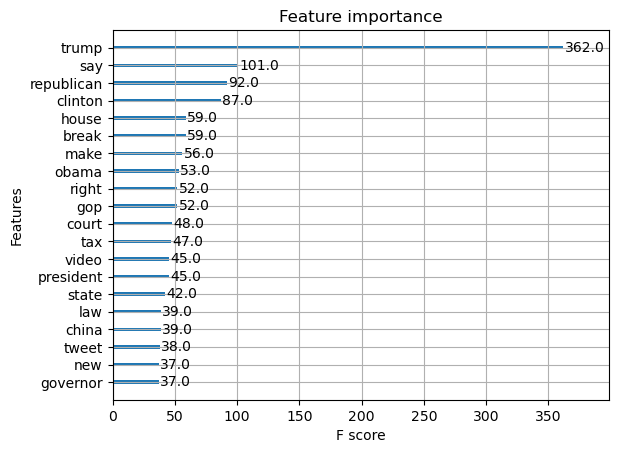

In [47]:
# Convert feature names to a list
best_xgb_model.get_booster().feature_names = list(tfidf_vectorizer.get_feature_names_out())

# Plot feature importance
xgb.plot_importance(best_xgb_model, max_num_features=20)  # Optional: limit to top 20 features
plt.show()

In [48]:
!pip install shap

In [ ]:
import shap
import numpy as np
import matplotlib.pyplot as plt

# Create the SHAP explainer
explainer = shap.TreeExplainer(best_xgb_model)
shap_values = explainer.shap_values(X_test)

# For binary classification, shap_values returns a list with two arrays:
# shap_values[0] - Contributions for class 0 (real news)
# shap_values[1] - Contributions for class 1 (fake news)

# Plot for class 0 (real news)
shap.summary_plot(shap_values[0], X_test, feature_names=tfidf_vectorizer.get_feature_names_out(), show=True)

# Plot for class 1 (fake news)
shap.summary_plot(shap_values[1], X_test, feature_names=tfidf_vectorizer.get_feature_names_out(), show=True)

In [56]:
# Create the SHAP explainer
explainer = shap.TreeExplainer(best_xgb_model)

# Get the SHAP values for the test set
shap_values = explainer.shap_values(X_test)

# Check the shape of SHAP values for both classes (real news and fake news)
print("Shape of SHAP values for class 0 (real news):", shap_values[0].shape)
print("Shape of SHAP values for class 1 (fake news):", shap_values[1].shape)

# Now plot for class 0 (real news)
shap.summary_plot(shap_values[0], X_test, feature_names=tfidf_vectorizer.get_feature_names_out(), show=True)

# Now plot for class 1 (fake news)
shap.summary_plot(shap_values[1], X_test, feature_names=tfidf_vectorizer.get_feature_names_out(), show=True)

Shape of SHAP values for class 0 (real news): (100,)
Shape of SHAP values for class 1 (fake news): (100,)


AssertionError: Summary plots need a matrix of shap_values, not a vector.